## A faire ##
- adaptive timestep, par ex si la diff entre loss_old et loss new est trop grande-> reduire
- corss-validation?

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
from UtilityFunctions import *
from datapreprocessing import *
from implementations import *
from patternsmissingvalues import *

In [3]:
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

# Exploratory Data Analysis

In [4]:
y.shape,tX.shape,ids.shape

((250000,), (250000, 30), (250000,))

In [5]:
np.around(tX[0],decimals=2)

array([ 1.3847e+02,  5.1660e+01,  9.7830e+01,  2.7980e+01,  9.1000e-01,
        1.2471e+02,  2.6700e+00,  3.0600e+00,  4.1930e+01,  1.9776e+02,
        1.5800e+00,  1.4000e+00,  2.0000e-01,  3.2640e+01,  1.0200e+00,
        3.8000e-01,  5.1630e+01,  2.2700e+00, -2.4100e+00,  1.6820e+01,
       -2.8000e-01,  2.5873e+02,  2.0000e+00,  6.7440e+01,  2.1500e+00,
        4.4000e-01,  4.6060e+01,  1.2400e+00, -2.4800e+00,  1.1350e+02])

In [6]:
(tX[:,0].shape,np.std(tX[:,0]))

((250000,), 406.34483401069514)

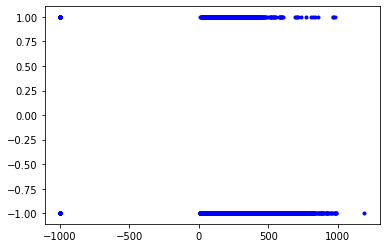

In [7]:
plt.scatter(tX[:,0],y, marker=".", color='b')

Ne sont pas des outliers, mais contiennent juste des missing values à -999

## Correlation Matrix:

(4, 6)
(4, 12)
(4, 26)
(4, 27)
(4, 28)
(6, 12)
(6, 26)
(6, 27)
(6, 28)
(9, 29)
(12, 26)
(12, 27)
(12, 28)
(23, 24)
(23, 25)
(24, 25)
(26, 27)
(26, 28)
(27, 28)


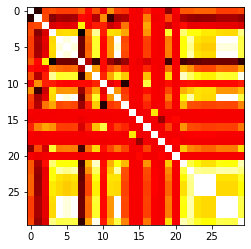

In [8]:
#corrcoef prod des vals normalisées à partir de la mat de correlation
cov = np.cov(tX.T)
#print(cov.shape, np.max(cov))
corr = np.corrcoef((tX.T))
#print(corr.shape, (corr))
plt.imshow(corr, cmap='hot')
res = np.where(corr > 0.95) #arbitrary threshold for strong correlation
listOfCoordinates= list(zip(res[0], res[1]))
listOfCoordinates = [cord for cord in listOfCoordinates if cord[0] != cord[1]] #remove diagonal
listOfCoordinates = {tuple(sorted(t)): t for t in listOfCoordinates}#remove commutative elements
for cord in listOfCoordinates:
        print(cord)

We identify strong correlations between the features listed above. However, these results should be interpreted carefully because a lot of the strong correlations observed might be due to the -999 missing values. However, this can still be useful if the missing values aren't distributed randomly in the data

## PCA:

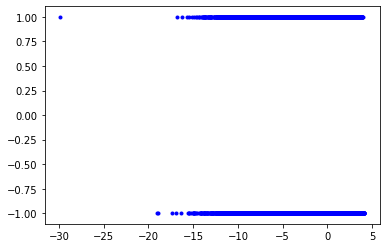

In [9]:
X_pca = pca(tX)
plt.scatter(X_pca[:,0],y, marker=".", color='b')
plt.show()

Plot of the first PCA component against the output

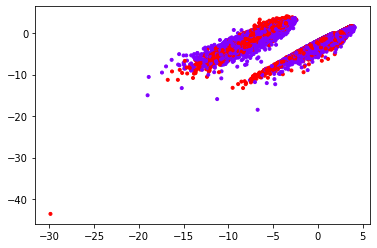

In [10]:
import matplotlib.cm as cm # To colour dots of scatter plot
colors = cm.rainbow(y)
plt.scatter(X_pca[:,0],X_pca[:,1], marker=".", color=colors)
plt.show()

Plot of the first PCA component against the second PCA component. The dots are color labeled according to their output value y. Unfortunately, we notice that the clusters identified in the plot do not discriminate between the 2 output categories.

## Missing values positions :

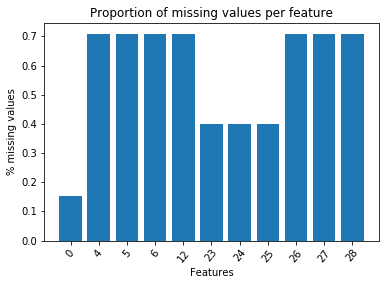

Total number of missing values:  1580052 Remaining number of missing values:  0


In [11]:
tX2 = tX.copy()
res = []
for el in tX2.T:
    res.append(el[el > -999])

mu = [np.mean(el) for el in res]
sigma = [np.std(el) for el in res]

for col, mu1, sigma1 in zip(tX2.T,mu,sigma):
    col[col == -999] = np.random.normal(mu1, sigma1, np.sum([col == -999][0]))
    
#create a mask of values 0 and 1, the ones mark the positions of the missing values
missing_val = np.zeros(tX.shape)
missing_val[tX==-999] = 1
total_cols = np.sum(missing_val, axis=0)/y.shape
total_rows = np.sum(missing_val, axis=1)/np.shape(tX)[1]

fig, ax = plt.subplots()
plt.title('Proportion of missing values per feature')
plt.xlabel('Features')
plt.ylabel('% missing values')
y_plot = total_cols[total_cols>0.1]
x_plot = range(0,len(y_plot))
ax.bar(x_plot,y_plot)
ax.set_xticks(x_plot)
ax.set_xticklabels(np.where(total_cols>0.1)[0])
plt.xticks(rotation=50)
plt.show()


print("Total number of missing values: ", np.sum(tX==-999), "Remaining number of missing values: ",np.sum(tX2==-999))

We notice that features 0,4,5,6,12,26,27,28 have a very high percentage of missing values, whereas other feature don't have any.

## Plot distributions of the features (w/o missing values) :

In [15]:
tX_reduced = tX[: ,total_cols < 0.5] #select only cols where less than 50% val missing and < 30% for rows
tX_reduced = tX_reduced[total_rows<0.3, :] #and < 30% for rows
y_reduced = y[total_rows<0.3]

tX_no_missing_val = []

#figure
fig,ax = plt.subplots(5, 6)

fig.suptitle('Distribution of 30 features values', fontsize=180)
fig.set_figheight(150)
fig.set_figwidth(150)

for i in range(tX.shape[1]):
    tXcol = [el for el in tX[:,i] if el > -999]  #keep only values in the normal range for the plot
    tX_no_missing_val.append(np.array(tXcol))
    ax[int(i/6),i%6].hist(tXcol, bins=40, log=True)
    ax[int(i/6),i%6].set_xticks(np.linspace(np.min(tXcol),np.max(tXcol),num=5))
    ax[int(i/6),i%6].set_xticklabels(np.around(np.linspace(np.min(tXcol),np.max(tXcol),num=5),2),fontsize=80)
    
tX_no_missing_val = np.array(tX_no_missing_val).T

discrete_features=[]
for ind,el in enumerate(tX_no_missing_val):
    if(len(np.unique(np.around(el,4))) < 1000):
        discrete_features.append(ind)
        print(np.unique(np.around(el,4)))


plt.show()

[0. 1. 2. 3.]


The features number 22 is a feature with discrete values, it can only take the following values: 0. 1. 2. 3.

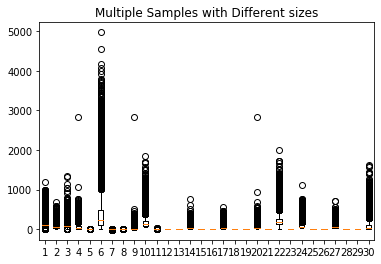

In [17]:
fig2, ax2 = plt.subplots()
ax2.set_title('Boxplot for all the features')
ax2.boxplot(tX_no_missing_val)
plt.show()

<BarContainer object of 30 artists>

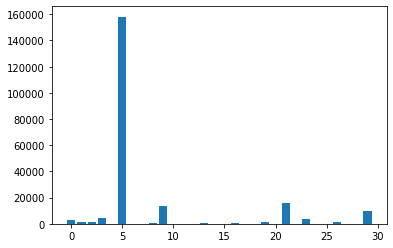

In [38]:
variance = []
for el in tX_no_missing_val:
    variance.append(np.var(el))
plt.bar(range(0,len(variance)),variance)
plt.show()

A closer look at the variance for each feature

# Global data preprocessing :

In [ ]:
x, mean_x, std_x = standardize(tX)
tX = adding_offset(x)
xtrain,ytrain,xtest,ytest=split_data(tX,y,0.9)
pX=add_higher_degree_terms(x,5)#equivalent to build poly in multiple dimensions
pX=adding_offset(x)
xtrainpol,ytrainpol,xtestpol,ytestpol=split_data(pX, y, 0.9) #on polynomial version,with ration= 0.9 and default seed=1

# Standard implementations

## Least squares gradient descent :

In [ ]:
initial_w = np.zeros(np.shape(tX)[1])
gamma = 0.0825
max_iters = 1000
final_w_gd, final_loss_gd = least_squares_GD(y, tX, initial_w, max_iters, gamma)

## Least squares stochastic gradient descent :

In [ ]:
gamma = 0.005
max_iters = 500
final_w_sgd, final_loss_sgd = least_squares_SGD(y, tX, initial_w, max_iters, gamma)

## Least squares with normal equation  

In [ ]:
w_ne,loss_ne= least_squares(y, tX)

#### on polynomial version of the data set :

In [30]:
w_ne_pol, loss_ne_pol = least_squares(y, pX)

Loss=0.3394455984893396, w0=-999.4173451011517, w1=0.031342169911756444


#### and with split of test and train data :

In [31]:
w_ne_pol_train, loss_ne_pol_train=least_squares(ytrainpol, xtrainpol)
rmse_ne_pol_train=rmse(loss_ne_pol_train)
loss_ne_pol_test= compute_loss_linear(ytestpol, xtestpol, w_ne_pol_train)
rmse_ne_pol_test=rmse(loss_ne_pol_test)
print(" Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(tr=rmse_ne_pol_train, te=rmse_ne_pol_test))

Loss=0.33924422861263215, w0=-1584.1845283059572, w1=0.03149827750621196
 Training RMSE=0.824, Testing RMSE=0.826


## Ridge regression :

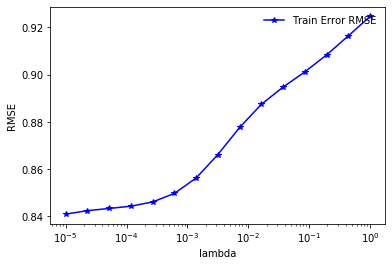

In [32]:
lambdas = np.logspace(-5, 0, 15)
rmse_rr = []
for ind, lambda_ in enumerate(lambdas):
        w_rr,loss_rr = ridge_regression(y, tX, lambda_)
        rmse_rr.append(rmse(loss_rr))

plot_implementation(rmse_rr, lambdas)

#### on polynomial version of the data set :

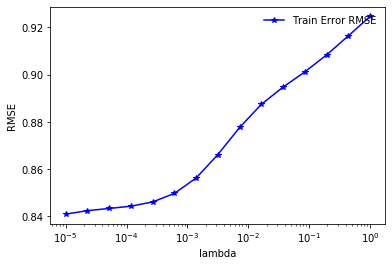

In [33]:
lambdas = np.logspace(-5, 0, 15)
rmse_rr_pol = []
for ind, lambda_ in enumerate(lambdas):
        w_rr_pol,loss_rr_pol = ridge_regression(y, pX, lambda_)
        rmse_rr_pol.append(rmse(loss_rr_pol))

plot_implementation(rmse_rr_pol, lambdas)

#### and with split of test and train data :

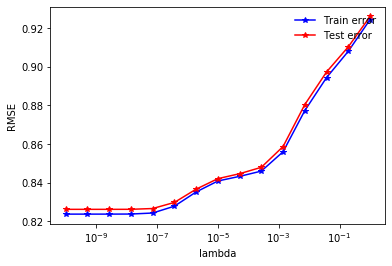

In [34]:
lambdas = np.logspace(-10, 0, 15)
rmse_rr_pol_train = []
rmse_rr_pol_test = []
for ind, lambda_ in enumerate(lambdas):
        w_rr_pol,loss_rr_pol_train = ridge_regression(ytrainpol,xtrainpol , lambda_)
        rmse_rr_pol_train.append(rmse(loss_rr_pol_train))
        rmse_rr_pol_test.append(rmse(compute_loss_linear(ytestpol,xtestpol,w_rr_pol)))
plot_train_test(rmse_rr_pol_train, rmse_rr_pol_test, lambdas)
#JEROME: plot a l'air normal, exactement meme erreur pour test et train bc the dataset is hge so there is no big difference between trin and test

## Logistic regression

### Logistic regression using gradient descent

We have to rescale y to get it between 0 and 1 for the loss function ot work properly. Moreover, this method is very sensitive so we start with an already goo approximation of the weights that we get fro the methods used previously.

In [13]:
initial_w = w_ne_pol_train
max_iters = 100
gamma=0.000001
w_lr,loss_lr=logistic_regression(rescale_y(y), tX, initial_w, max_iters,gamma)
a = rmse(compute_loss_linear(y,tX,w_lr))
print("Root mean square error: ",a)
#J: pas encore au top

NameError: name 'w_ne_pol_train' is not defined

#### With split of train and test data :

In [68]:
w_lr_pol,loss_lr_pol_train = logistic_regression(rescale_y(ytrainpol),xtrainpol,initial_w, max_iters,gamma)
rmse_lr_pol_train = rmse(compute_loss_linear(ytrainpol,xtrainpol,w_lr_pol))
rmse_lr_pol_test = rmse(compute_loss_linear(ytestpol,xtestpol,w_lr_pol))
print("Root mean square error for test: {tr:.3f} and train: {te:.3f} ".format(tr=rmse_lr_pol_train, te=rmse_lr_pol_test))

Loss=155958.11562598764, w0=-183.478, w1=-5.30049542991256
invalid value encountered in double_scalars
Root mean square error for test: 4023.808 and train: 4023.172 


### Logistic regression using Newton

In [15]:
max_iters = 25
gamma = 0.01
initial_w = np.zeros(np.shape(tX)[1])
w_lrn, loss_lrn=logistic_regression_newton(rescale_y(y),tX,initial_w,max_iters,gamma)
#to compare with least squares error
a = rmse(compute_loss_linear(y, tX, w_lrn))
print("Root mean square error: ",a)

Loss=173286.79513998624, w0=1.6078173127653807e-06, w1=-0.0001440225449348631
Loss=172489.2515999439, w0=3.1997182244358773e-06, w1=-0.00028662428628024373
Loss=171707.50053184963, w0=4.776166873808886e-06, w1=-0.0004278500073900915
Loss=170941.07385066204, w0=6.33974576133678e-06, w1=-0.0005677008993452048
Loss=170189.57003988425, w0=7.890124771684494e-06, w1=-0.0007062384929699838
Loss=169452.54139555924, w0=9.42880958776149e-06, w1=-0.0008434759895517807
Loss=168729.60166591697, w0=1.095542740091271e-05, w1=-0.0009794714317328613
Loss=168020.3436048129, w0=1.2471585117290741e-05, w1=-0.0011142351496725134
Loss=167324.41827910877, w0=1.3978304284848477e-05, w1=-0.0012477860646037087
Loss=166641.46836931873, w0=1.5474844004490508e-05, w1=-0.0013801820550023258
Loss=165971.13543563455, w0=1.69640067698118e-05, w1=-0.0015113969903226198
Loss=165313.12005807657, w0=1.8445967027987953e-05, w1=-0.0016414668573870726
Loss=164667.10802471856, w0=1.992112060430262e-05, w1=-0.00177041454597089

#### on polynomial version of the data set :

In [62]:
w_lrn, loss_lrn=logistic_regression_newton(rescale_y(y),pX,initial_w,max_iters,gamma)
a = rmse(compute_loss_linear(y, tX, w_lrn))
print("Root mean square error: ",a)

Loss=173286.79513998624, w0=-3.9903487548828127, w1=0.0001259555727328916
Loss=172401.77537194264, w0=-7.986554931640626, w1=0.0002514097959701758
Loss=171518.22683683038, w0=-11.982096679687501, w1=0.0003768123533072867
Loss=170636.0483107027, w0=-15.969350341796876, w1=0.000501873177174275
Root mean square error:  0.9924409624336752


### Regularized logistic regression

Loss=153569.38131219437, λ=1e-10, w0=-25.318964965820314, w1=0.0005027693058036675
Loss=12839999823458.75, λ=10000000000.0, w0=-25.318964965820314, w1=0.0005027693058036675


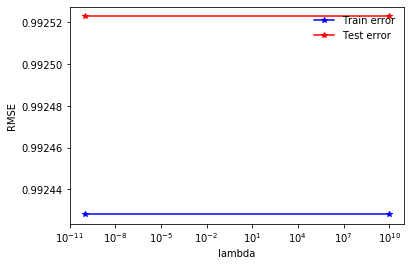

In [72]:
lambdas = np.logspace(-10, 10, 2)
rmse_rr_pol_train = []
rmse_rr_pol_test = []
for ind, lambda_ in enumerate(lambdas):
        w_rr_pol,loss_rr_pol_train = reg_logistic_regression(ytrainpol,xtrainpol ,lambda_,initial_w,max_iters,gamma)
        rmse_rr_pol_train.append(rmse(compute_loss_linear(ytrainpol,xtrainpol,w_rr_pol)))
        rmse_rr_pol_test.append(rmse(compute_loss_linear(ytestpol,xtestpol,w_rr_pol)))
plot_train_test(rmse_rr_pol_train, rmse_rr_pol_test, lambdas)
#J: test and train error are const, inde of lambda??

Remark: to be able to compare the train et test losses, we have to calculate them both using the same loss function, we opted for the mse loss function as it's value is on the same scale as the output

## End of required functions ##
#### We now begin more complex analysis ####

In [39]:
#### Example - base mode
gamma=0.5
ws_1,log_likelihoods_1 = logistic_regression(rescale_y(y), tX, np.random.rand(tX.shape[1])/1000000,1, gamma)
plt.scatter(rescale_predictions(compute_p(ws_1[-1],tX))[1:1000],y[1:1000], marker=".", color='b')
##AA : prend beaucoup de temps ...

loss=inf


In [40]:
ws_2, log_likelihoods_2 = logistic_regression(rescale_y(y), tX, np.random.rand(tX.shape[1])/1000000,10,gamma)
#plt.scatter(rescale_predictions(compute_p(ws_2[-1],tX))[1:1000],y[1:1000], marker=".", color='b')
#np.linalg.norm(ws_1[-1]-ws_2[-1])

/Users/anne-aimee/Desktop/Projet-Super-Genial-/project1/scripts/UtilityFunctions.py:171: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(t)/(1+np.exp(t))


loss=nan


# Outliers Management

##### replace -999 by average value

In [31]:
tX_corr = set_missing_explanatory_vars_to_mean(tX)

In [32]:
tX_corr[:,1:10]

array([[ 0.72343805,  0.52317289,  0.62968263, ...,  0.41016488,
         0.41108299,  0.50073461],
       [ 0.77526501,  0.56264922,  0.64215782, ..., -1.90048197,
         0.41202647,  0.40880848],
       [-1.90048197,  0.77811391,  0.69456379, ..., -1.90048197,
         0.41127676,  0.42555126],
       ...,
       [ 0.64728354,  0.54363654,  0.57896063, ..., -1.90048197,
         0.4095282 ,  0.45518677],
       [ 0.62304826,  0.44867927,  0.56275072, ..., -1.90048197,
         0.41177734,  0.43516602],
       [-1.90048197,  0.57184875,  0.56740816, ..., -1.90048197,
         0.40868622,  0.42126753]])

In [33]:
tX_corr_pca = pca(tX_corr)

/Users/jerome/Documents/EPFL/MA1/Machine Learning/Projet-Super-Genial-/project1/scripts/UtilityFunctions.py:101: RuntimeWarning: divide by zero encountered in true_divide
  tX_centered = np.nan_to_num((tX - np.mean(tX, 0)) / np.std(tX, 0)) ## Better solution required!!
/Users/jerome/Documents/EPFL/MA1/Machine Learning/Projet-Super-Genial-/project1/scripts/UtilityFunctions.py:101: RuntimeWarning: invalid value encountered in true_divide
  tX_centered = np.nan_to_num((tX - np.mean(tX, 0)) / np.std(tX, 0)) ## Better solution required!!


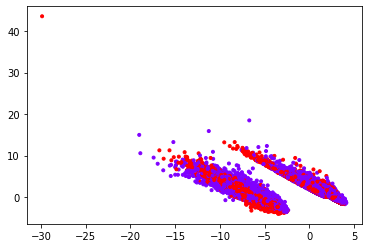

In [38]:
colors = cm.rainbow(y)
plt.scatter(tX_corr_pca[:,0],tX_corr_pca[:,1], marker=".", color=colors)

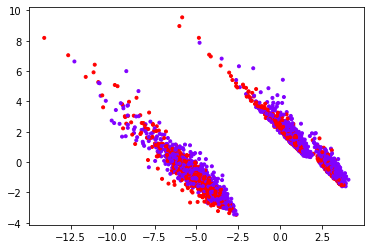

In [39]:
colors = cm.rainbow(y[1:5000])
plt.scatter(tX_corr_pca[1:5000,0],tX_corr_pca[1:5000,1], marker=".", color=colors)

##### Removing outliers

In [ ]:
#find and delete outlier
ind = np.arange(len(tX_corr_pca[:,0]))
ind_outliers = ind[np.where(tX_corr_pca[:,0] < -50)] # find a suitable criterion, 
y_cleared = np.delete(y,ind_outliers)
tX_corr_cleared = np.delete(tX_corr_pca,ind[np.where(tX_corr_pca[:,0] < -50)],axis=0)

In [ ]:
print(y_cleared.shape,tX_corr_cleared.shape)

In [ ]:
tX_corr_cleared_w0 = adding_offset(tX_corr_cleared)

In [ ]:
ws_5,log_likelihoods_5 = logistic_regression(rescale_y(y_cleared), tX_corr_cleared_w0, np.random.rand(tX_corr_cleared_w0.shape[1])/1000000,10,gamma)

In [ ]:
plt.scatter(rescale_predictions(compute_p(ws_5[-1],tX_corr_cleared_w0))[1:1000],y_cleared[1:1000], marker=".", color='b')

In [ ]:
ws_6, log_likelihoods_6 = logistic_regression(rescale_y(y_cleared), tX_corr_cleared_w0, np.random.rand(tX_corr_cleared_w0.shape[1])/1000000,10,gamma)

In [ ]:
plt.scatter(rescale_predictions(compute_p(ws_6[-1],tX_corr_cleared_w0))[1:1000],y_cleared[1:1000], marker=".", color='b')

In [ ]:
np.linalg.norm(ws_5[-1]-ws_6[-1])

In [ ]:
np.linalg.norm(ws_3[-1]-ws_5[-1])

In [ ]:
print(ws_3[-1],ws_5[-1])

# Taking into account patterns for the handling of missing values

In [ ]:
DATA_TEST_PATH = "../data/test.csv/test.csv"
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
DATA_TRAIN_PATH = "../data/train.csv/train.csv" # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [ ]:
# Test that in both test and train data the same columns are full of gaps
tX_mv = sum(tX == -999) # Array with columnwise count of faulty measurements in training data
tX_mv[tX_mv > 0] = 1 
tX_test_mv = sum(tX_test == -999) # Array with columnwise count of faulty measurements in test data
tX_test_mv[tX_test_mv > 0] = 1

np.linalg.norm(tX_mv-tX_test_mv) # = 0 means both training and test data have values missing only in the excact same explanatory variables.

In [ ]:
# Missing values don't appear to be random
tX_mv = sum(tX == -999)
tX_test_mv = sum(tX_test == -999)

print(tX_mv,tX_test_mv) # Arrays with columnwise counts of faulty measurements in training and test data

In [ ]:
ind = np.arange(tX.shape[1])
tX_col_mv = tX[:,ind[np.where(tX_mv > 0)]]
test = np.zeros(tX_col_mv.shape)
test[np.where(tX_col_mv == -999)] = 1
print(test[1:10,:]) # Extracted coulums that contain -999s. '1' represents missing value, '0' otherwise.

In [ ]:
np.flip(np.power(10,np.arange(test.shape[1]),dtype=np.int64)) # Sleight of hand: matrix multiplication  with the following array.

In [ ]:
np.dot(test,np.flip(np.power(10,np.arange(test.shape[1]),dtype=np.int64))) # The pattern of missing columns is represented by an array of numbers representing all samples in the usual order. The numbers are binary code for the matrix of the extracted columns just above.

In [ ]:
np.unique(np.dot(test,np.power(10,np.arange(test.shape[1]),dtype=np.int64))) # All the different configurations of the missing values. There are only six of them.

#### Pattern of missing values and logistic regession

In [ ]:
# Splitting the data...
tX_split, ind_row_groups, groups_mv_num = split_data_according_to_pattern_of_missing_values(tX) # => regroupement of the steps performed above
y_split = split_y_according_to_pattern_of_missing_values(y, ind_row_groups)

'''import matplotlib.cm as cm

for tX_group, y_group in zip(tX_split,y_split):
    tX_group_pca = pca(tX_group)
    colors = cm.rainbow(y_group)
    plt.scatter(tX_group_pca[:,0],tX_group_pca[:,1], marker=".", color=colors)'''

# ... and finding each subgroup's the optimal weights as well as predicting the y's of the training set using linear regression
#     => condensed version is the function 'find_optimal_weights_pattern_mv'

ws_groups = [] # list to stock weights of subgroups
y_pred = np.zeros([len(y)]) # initialize array y_pred

for tX_group, y_group, ind_row_group in zip(tX_split,y_split,ind_row_groups) :
    #print(tX_group, y_group, ind_row_group)
    
    # All-zero columns appear in the reduced data sets. They interfere with the calculation of the jacobean matrix.
    # The corresponding weights are set to zero and the other weights are determined using a further reduced dataset without those columns.
    
    ind_col_non_zero = np.arange(len(tX_group[0,:]))[sum(tX_group**2)>0]
    ws_1,log_likelihoods_1 = logistic_regression(rescale_y(y_group), tX_group[:,ind_col_non_zero], np.random.rand(tX_group[:,ind_col_non_zero].shape[1])/1000000,10,gamma)
    ws_2,log_likelihoods_2 = logistic_regression(rescale_y(y_group), tX_group[:,ind_col_non_zero], np.random.rand(tX_group[:,ind_col_non_zero].shape[1])/1000000,10,gamma)
    assert np.allclose(ws_1[-1], ws_2[-1]) # The weights are calculated twice with different initial ws => asserting that they are the same.
    w = np.zeros(len(tX_group[0,:]))
    w[ind_col_non_zero] = ws_1[-1]
    ws_groups.append(w)
    y_pred[ind_row_group] = rescale_predictions(compute_p(w,tX_group))

plt.scatter(y_pred[1:500],y[1:500], marker=".", color='b') # Plotting the predictions against the known values of the training set.

In [ ]:
tX_split_test, ind_row_groups_test, groups_mv_num_test = split_data_according_to_pattern_of_missing_values(tX_test)


''' Auxiliary function that calculates the predictions of each subgroup, joins them together in the right order
    and rescales the predictions so that they lie between -1 and 1'''
y_pred_test = predict_y_lr_weights_pattern_mv(ws_groups, tX_split_test,ind_row_groups_test,tX_test.shape[0])

In [ ]:
# The same with helper functions
DATA_TRAIN_PATH = "../data/train.csv/train.csv" # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [ ]:
# Splitting the data by patterns
tX_split, ind_row_groups, groups_mv_num = split_data_according_to_pattern_of_missing_values(tX)
y_split = split_y_according_to_pattern_of_missing_values(y, ind_row_groups)

In [ ]:
# Adding interaction terms to the split data and calculating the optimal weights of each subgroup.
ws_groups, y_pred = find_optimal_weights_pattern_mv(tX_split_test, ind_row_groups,y_split,tX.shape[0])
plt.scatter(y_pred,y, marker=".", color='b')

In [ ]:
plt.scatter(y_pred[ind_row_groups[4]][0:800],y[ind_row_groups[4]][0:800], marker=".", color='b')

In [ ]:
DATA_TEST_PATH = "../data/test.csv/test.csv"
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_split_test, ind_row_groups_test, groups_mv_num_test = split_data_according_to_pattern_of_missing_values(tX_test)
y_pred_test = predict_y_lr_weights_pattern_mv(ws_groups, tX_split_test,ind_row_groups_test,tX_test.shape[0])

In [ ]:
y_pred_tX = y_pred
y_pred_test_tX = y_pred_test
ws_groups_tX = ws_groups

### Interactions between variables

In [ ]:
x = np.array([[1,2,3],[4,5,6]])
print(add_interaction_terms(x),add_square_terms(x))

In [ ]:
print(add_higher_degree_terms(x, 3))

# Best version so far: Pattern of missing values, interactions between variables and logistic regession

#### Squares of explanatory variables

In [ ]:
DATA_TRAIN_PATH = "../data/train.csv/train.csv" # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [ ]:
# Splitting the data...
tX_split, ind_row_groups, groups_mv_num = split_data_according_to_pattern_of_missing_values(tX)
y_split = split_y_according_to_pattern_of_missing_values(y, ind_row_groups)

In [ ]:
# Adding interaction terms to the split data and calculating the optimal weights of each subgroup.
ws_groups, y_pred = find_optimal_weights_pattern_mv(add_exponential_terms_to_split_data(tX_split_test,2), ind_row_groups,y_split,tX.shape[0])
plt.scatter(y_pred,y, marker=".", color='b')

In [ ]:
plt.scatter(y_pred[ind_row_groups[4]][0:800],y[ind_row_groups[4]][0:800], marker=".", color='b')

In [ ]:
DATA_TEST_PATH = "../data/test.csv/test.csv"
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_split_test, ind_row_groups_test, groups_mv_num_test = split_data_according_to_pattern_of_missing_values(tX_test)
y_pred_test = predict_y_lr_weights_pattern_mv(ws_groups, add_exponential_terms_to_split_data(tX_split_test,2),ind_row_groups_test,tX_test.shape[0])

In [ ]:
y_pred_squares = y_pred
y_pred_test_squares = y_pred_test
ws_groups_squares = ws_groups

In [ ]:
len(y_pred_test_squares)

#### Cubic values of explanatory variables

In [ ]:
DATA_TRAIN_PATH = "../data/train.csv/train.csv" # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [ ]:
# Splitting the data...
tX_split, ind_row_groups, groups_mv_num = split_data_according_to_pattern_of_missing_values(tX)
y_split = split_y_according_to_pattern_of_missing_values(y, ind_row_groups)

In [ ]:
# Adding interaction terms to the split data and calculating the optimal weights of each subgroup.
ws_groups, y_pred = find_optimal_weights_pattern_mv(add_exponential_terms_to_split_data(tX_split,3), ind_row_groups,y_split,tX.shape[0])
plt.scatter(y_pred,y, marker=".", color='b')

In [ ]:
plt.scatter(y_pred[ind_row_groups[4]][0:800],y[ind_row_groups[4]][0:800], marker=".", color='b')

In [ ]:
DATA_TEST_PATH = "../data/test.csv/test.csv"
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_split_test, ind_row_groups_test, groups_mv_num_test = split_data_according_to_pattern_of_missing_values(tX_test)
y_pred_test = predict_y_lr_weights_pattern_mv(ws_groups, add_exponential_terms_to_split_data(tX_split_test,3),ind_row_groups_test,tX_test.shape[0])

In [ ]:
y_pred_cubic = y_pred
y_pred_test_cubic = y_pred_test
ws_groups_cubic = ws_groups

In [ ]:
groups_no_conv = np.array([1,4])

In [ ]:
y_pred_comb = y_pred_cubic
for group in groups_no_conv:
    y_pred_comb[ind_row_groups[group]] = y_pred_squares[ind_row_groups[group]]

In [ ]:
plt.scatter(y_pred_comb[ind_row_groups[1]][0:800],y[ind_row_groups[1]][0:800], marker=".", color='b')

In [ ]:
for group in groups_no_conv:
    y_pred_test[ind_row_groups_test[group]] = y_pred_test_squares[ind_row_groups_test[group]]

#### Interactions beween all variables

In [ ]:
DATA_TRAIN_PATH = "../data/train.csv/train.csv" # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [ ]:
# Splitting the data...
tX_split, ind_row_groups, groups_mv_num = split_data_according_to_pattern_of_missing_values(tX)
y_split = split_y_according_to_pattern_of_missing_values(y, ind_row_groups)

In [ ]:
# Adding interaction terms to the split data and calculating the optimal weights of each subgroup.
ws_groups, y_pred = find_optimal_weights_pattern_mv(add_interaction_terms_to_split_data(tX_split), ind_row_groups,y_split,tX.shape[0])
plt.scatter(y_pred,y, marker=".", color='b')

In [ ]:
# Adding interaction terms to the split data and calculating the optimal weights of each subgroup.
ws_groups, y_pred = find_optimal_weights_pattern_mv(add_interaction_terms_to_split_data(tX_split), ind_row_groups,y_split,tX.shape[0])
plt.scatter(y_pred,y, marker=".", color='b')

In [ ]:
plt.scatter(y_pred[ind_row_groups[4]][0:800],y[ind_row_groups[4]][0:800], marker=".", color='b')

In [ ]:
DATA_TEST_PATH = "../data/test.csv/test.csv"
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_split_test, ind_row_groups_test, groups_mv_num_test = split_data_according_to_pattern_of_missing_values(tX_test)
y_pred_test = predict_y_lr_weights_pattern_mv(ws_groups, add_interaction_terms_to_split_data(tX_split_test),ind_row_groups_test,tX_test.shape[0])

In [ ]:
y_pred_interact = y_pred
y_pred_test_interact = y_pred_test
ws_groups_interact = ws_groups

#### Standartization - if one uses square and cubic values they might be larger of smaller

In [ ]:
def standardize(x):

    centered_data = x - np.mean(x, axis=0)
    std_data = centered_data / np.std(centered_data, axis=0)
    
    return std_data

### !!! Overfitting

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = '../data/predicted.csv' # TODO: fill in desired name of output file for submission
tX_test, mean_x, std_x = standardize(tX_test)
tX_test  = np.c_[np.ones(tX_test.shape[0]), tX_test]
y_pred = predict_labels(w1, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [ ]:
#implementer 10% du train set comme test set